# W207 Summer 2018 Final Project 
---

**Authors:** Divya Gorantla, Ram Iyer, Tiffany Jaya, Steve Sanders <br/>
**Date:** 5 August 2018

---

## Table of Contents

1. [Introduction](#introduction)
2. [Exploratory Data Analysis](#eda)
  1. [Load libraries](#load-libraries)
  2. [Load data](#load-data)
  3. [Identify the train labels](#identify-the-train-labels)
  4. [Identify the train features](#identify-the-train-features)
  5. [Address concerns about the datasets](#address-concerns-about-the-datasets)
3. [Feature Engineering](#feature-engineering)
4. [Models](#models)
  1. [Model Results](#model-results)
5. [Ensemble Models](#ensemble-models)
  1. [Ensemble Results](#ensemble-results)
6. [Stack Models](#stack-models)
  1. [Stack Results](#stack-results)
7. [Conclusion](#conclusion)
8. [References](#references)
9. [Appendix](#appendix)
  1. [Cross Validation](#appendix-cv)
---

<a id='introduction'/>

## Introduction

Our goal in this project is to classify an observed 30 x 30 meter land into one of the seven forest cover types found in the Roosevelt National Forest of Northern Colarado: 

| Forest Cover Type  | Tree   | Leaf  | 
| ------------------ |:------:| -----:| 
| Spruce/Fir         | <img src='./img/spruce-tree.jpg' alt='Spruce tree' height='65px' width='65px'/><br /><img src='./img/fir-tree.jpg' alt='Fir tree' height='65px' width='65px'/> | <img src='./img/spruce.jpg' alt='Spruce leaf' height='65px' width='65px'/><br /><img src='./img/fir.jpg' alt='Fir leaf' height='65px' width='65px'/> | 
| Lodgepole Pine     | <img src='./img/lodgepole-pine-tree.jpg' alt='Lodgepole Pine tree' height='65px' width='65px'/> | <img src='./img/lodgepole-pine.jpg' alt='Lodgepole Pine leaf' height='65px' width='65px'/> | 
| Ponderosa Pine     | <img src='./img/ponderosa-pine-tree.jpg' alt='Ponderosa Pine tree' height='65px' width='65px'/> | <img src='./img/ponderosa-pine.jpg' alt='Ponderosa Pine leaf' height='65px' width='65px'/> |
| Cottonwood/Willow  | <img src='./img/cottonwood-tree.jpg' alt='Cottonwood tree' height='65px' width='65px'/><br /><img src='./img/willow-tree.jpg' alt='Willow tree' height='65px' width='65px'/> | <img src='./img/cottonwood.jpg' alt='Cottonwood leaf' height='65px' width='65px'/><br /><img src='./img/willow.jpg' alt='Willow leaf' height='65px' width='65px'/> |
| Aspen              | <img src='./img/aspen-tree.jpg' alt='Aspen tree' height='65px' width='65px'/> | <img src='./img/aspen.jpg' alt='Aspen leaf' height='65px' width='65px'/> | 
| Douglas-Fir        | <img src='./img/douglas-fir-tree.jpg' alt='Douglas-Fir tree' height='65px' width='65px'/> | <img src='./img/douglas-fir.jpg' alt='Douglas-Fir leaf' height='65px' width='65px'/> | 
| Krummholz <br />(stunted trees) | <img src='./img/krummholz-tree.jpg' alt='Krummholz tree' height='65px' width='65px'/> | |

Fortunately for us, 15,120 of these observations have been labeled to their respective forest cover types. We can then use this labeled dataset to train several different models and compare which model can best accurately classify the forest cover type based on just the cartographic information. 

What we have found is that random forest classifier perform best among the three models we have tested with an accuracy score of 77.2%.  


<a id='eda'/>

## Exploratory Data Analysis

All cartographic information that we use as features to determine the forest cover type has been collected by the US Geological Survey (USGS) and US Forest Service (USFS). The associating labels were derived separately by the USFS Region 2 Resource Information System. We download them from the Kaggle website via the Kaggle API. 

<a id='load-libraries'/>

### Load libraries

In [5]:
# general libraries
import pandas as pd
import numpy as np

# plot libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing (aka feature engineering)
from sklearn.preprocessing import normalize

# model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# model definition
from sklearn import svm as SVM
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# model metrics
from sklearn.metrics import accuracy_score

# define the random_state
random_state = 7

<a id='load-data'/>

### Load data

We used the Kaggle API to download the data directly from the Kaggle website. 

To use the Kaggle API, please follow these instructions:

1. Login to your Kaggle account
2. Select 'My account'
3. Select 'Create New API Token'
4. Place the token 'kaggle.json' into ~/.kaggle

We decided to comment out the code relating to the use of Kaggle API since it was tested in a MAC OS and cannot guarantee reliability in other OS.

In [9]:
# install the Kaggle API library
#!pip install kaggle

# download each ZIP file from the Kaggle website via the Kaggle API
#!kaggle competitions download -c forest-cover-type-prediction -p ./data 

# define each downloaded file
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'
SAMPLE_SUBMISSION_FILENAME = 'sampleSubmission.csv'

# define where the downloaded file will be stored
DATAPATH = './data/'

# unzip the files and load them as a panda DataFrame
def get_data(filename, unzip=False):
    '''Read CSV file (unzip or not) into a dataframe'''
    if unzip:
        zippath = DATAPATH + filename + '.zip'
        return pd.read_csv(zippath, compression='zip', header=0, sep=',', quotechar='"', index_col='Id')
    
    filepath = DATAPATH + filename
    return pd.read_csv(filepath, header=0, sep=',', quotechar='"', index_col='Id')

train = get_data(TRAIN_FILENAME, unzip=False)
test = get_data(TEST_FILENAME, unzip=False)
sample = get_data(SAMPLE_SUBMISSION_FILENAME, unzip=False)

In [10]:
# define the data
train_data = train.drop('Cover_Type', axis=1)
test_data = test

# define the labels
train_labels = train['Cover_Type']

In [11]:
# define additional labels, not defined in the dataset
cover_types = sorted(pd.unique(train['Cover_Type'])) # 1-7
cover_labels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
wilderness_types = list(range(1,5)) # 1-4
wilderness_labels = ['Rawah', 'Neota', 'Comanche', 'Cache la Poudre']
soil_types = list(range(1,41)) # 1-40
soil_labels = ['Cathedral family', 
               'Vanet', 
               'Haploborolis', 
               'Ratake family',
               'Vanet family',
               'Vanet - Wetmore families',
               'Gothic family',
               'Supervisor',
               'Troutville family',
               'Bullwark - Catamount families',
               'Bullwark - Catamount families',
               'Legault family',
               'Catamount family',
               'Pachic Argiborolis',
               '',
               'Cryaquolis',
               'Gateview family',
               'Rogert family',
               'Typic Cryaquolis',
               'Typic Cryaquepts',
               'Typic Cryaquolls',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Granile',
               'Leighcan family',
               'Leighcan family',
               'Como - Legault families',
               'Como family',
               'Leighcan - Catamount families',
               'Catamount family',
               'Leighcan - Catamount families',
               'Cryorthents',
               'Cryumbrepts',
               'Bross family',
               'Cryumbrepts',
               'Leighcan - Moran families',
               'Moran family - Cryorthents',
               'Moran family - Cryorthents'
              ]
soil_descriptions = ['Rock outcrop complex, extremely stony',
                     'Ratake families complex, very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, stony',
                     '',
                     'Limber families complex',
                     'very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock land complex, rubbly',
                     ' Rock land complex, stony',
                     'Rock land - Bullwark family complex, rubbly',
                     'Aquolis complex',
                     '',
                     'Cryoborolis complex',
                     'Cryaquolis complex',
                     'very stony',
                     'Borohemists complex',
                     'Typic Cryaquolls complex',
                     'Leighcan family, till substratum complex',
                     'till substratum, extremely bouldery',
                     'till substratum, extremely bouldery',
                     'extremely stony',
                     'warm, extremely stony',
                     'Catamount families complex, very stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'complex, extremely stony',
                     'Rock land - Legault family complex, extremely stony',
                     'complex, extremely stony',
                     'Rock outcrop - Leighcan family complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock land complex, extremely stony',
                     'Rock outcrop - Cryaquepts complex',
                     'Rock land - Cryumbrepts complex, extremely stony',
                     'Cryumbrepts - Cryorthents complex, extremely stony',
                     'Cryaquolls complex, extremely stony',
                     'Cryorthents - Leighcan family complex, extremely stony',
                     'Cryorthents - Rock land complex, extremely stony'
                    ]

<a id='identify-the-train-labels'/>

### Identify the train labels

There are 2,160 observations for each of the seven forest cover types. The classes are represented equally, which is great news, because we do not have to concern ourselves with misleading classification accuracy, a common problem that plagues an imbalanced dataset.

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

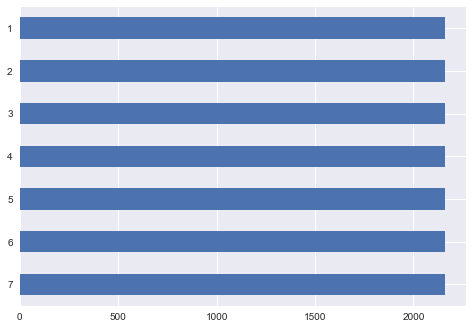

In [6]:
train_labels.value_counts().plot(kind='barh')
train_labels.value_counts()

<a id='identify-the-train-features'/>

### Identify the train features

In the train dataset, there are 15,120 observations with 54 features. 

In [7]:
print(train_data.shape)
train_data.columns

(15120, 54)


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In the test dataset, there are 565,892 observations which includes the 54 features found in the train dataset. In other words, we have validated that the train dataset is a good dataset to use as it shares the same cartographic information as the test dataset.

In [8]:
print(test.shape)
test.columns

(565892, 54)


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

Looking at the features, it is interesting to note that we do not see longitude and latitude values, which means we cannot validate the cartographic information to the actual geographic location. The 54 features are summarized in the following table below:

| Name                               | Measurement     | Description                                               |
| ----------------------------------:| ---------------:| ---------------------------------------------------------:|
| Elevation                          | meters          | Height above sea level                                    |
| Aspect                             | degrees azimuth | Compass direction that a slope faces<br/>0: North, 90: East, 180: South, 270: West<br/>Potential influence on temperature and soil | 
| Slope                              | degrees         | Degree of incline of a surface<br/>In other words, maximum rate of change of elevation<br/>Has gradient and aspect as components                                                     | 
| Horizontal_Distance_To_Hydrology   | meters          | Horizontal Distance to the nearest surface water features | 
| Vertical_Distance_To_Hydrology     | meters          | Vertical Distance to the nearest surface water features   | 
| Horizontal_Distance_To_Roadways    | meters          | Horizontal distance to the nearest roadway                | 
| Horizontal_Distance_To_Fire_Points | meters          | Horizontal distance to the nearest wildfire ignition points | 
| Hillshade_9am                      | 0 (dark) to 255 (light) | Hillshade index at 9 AM, summer solstice | 
| Hillshade_Noon                     | 0 (dark) to 255 (light) | Hillshade index at 12 PM, summer solstice | 
| Hillshade_3pm                      | 0 (dark) to 255 (light) | Hillshade index at 3 PM, summer solstice | 
| Wilderness_Area (4 binary columns) | 0 (absent) or 1 (present) | Wilderness area designation<br/>1: Rawah, 2: Neota, 3: Comanche, 4: Cache la Poudre | 
| Soil_Type (40 binary columns)      | 0 (absent) or 1 (present) | Soil type designation |



<a id='feature-engineering'/>

## Feature Engineering


In [9]:
# make a copy of the train data to be modified
fe_train_data = train_data.copy()
fe_train_labels = train_labels.copy()

### 1. Normalize Hillshade

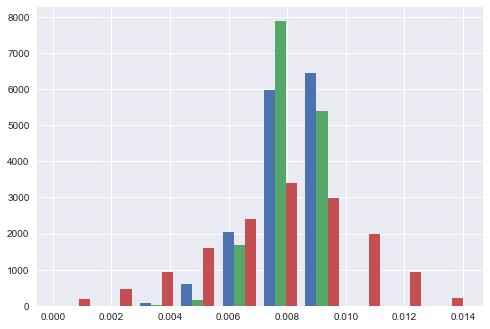

In [10]:
normalize_hillshade = normalize(train_data[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']], axis=0)
plt.hist(normalize_hillshade);

In [11]:
fe_train_data['Hillshade_9am'] = normalize_hillshade[:, 0]
fe_train_data['Hillshade_Noon'] = normalize_hillshade[:, 1]
fe_train_data['Hillshade_3pm'] = normalize_hillshade[:, 2]

In [ ]:
# baseline model
# Check to see if any improvement relative to original baseline accuracy shown below (Baseline model score, mean=0.7762, stdDev=0.0412)

X_train_mod = train_mod.iloc[:,:-1].values
y_train_mod = train_mod.iloc[:,-1:].values.ravel()

# Fit the baseline model with the cross validates params on the original feature set

baseline_model = RandomForestClassifier(n_estimators=50,max_depth=76)
baseline_model.fit(X_train_mod,y_train_mod)

scores = cross_val_score(baseline_model, X_train_mod, y_train_mod, cv=10)

print("Baseline model score after inserting new feature ('Hydrology_Distance_Is_Negative'), mean : {:7.4f}, stdDev : {:7.4f}".format(np.mean(scores),np.std(scores)))

### 2. Feature Scaling

To ensure that all numerical values are seen as "equally weighted" by the algorithm, we scale all of the features with 0 as the mean and 1 as standard deviation. We scale the test dataset using the training dataset parameters to ensure the numerical values are seen as "equally weighted."


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(train_data)
std_train_data = sc.transform(train_data)
std_test_data = sc.transform(test_data)

## Models

Based on our intuition of the use case, the problem that we are trying to solve is a multi-class classification problem. We come to this conclusion because we are trying to fit 54 features (of cartographic information) into 7 classes (of forest cover types). For this reason, we will look into multi-class classification methods to see which model performs the best classification of the problem at hand. 

The multi-class classification methods that we will compare are:

1. Logistic Regression (LR)
2. Naive Bayes (NB)
3. K-Nearest Neighbors (KNN)
4. Support Vector Machine (SVM)
5. Decision Tree (DT)
6. Neural Network 

Problem with train/test split
* split the dataset into two pieces so that the model can be trained and tested on different data
* problem: it provides a high variance estimate since changing which observations happen to be in the testing set can significantly change testing accuracy
* testing accuracy can change a lot depending on which observation happen to be in the testing set

Cross-validation: create multiple train/test split, calculate the testing accuracy for each, and average the results together 

define the parameters that will be searched using K-fold cross-validation

Reducing computational expense using RandomizedSearchCV

Searching many different parameters at once may be computationally infeasible
* For example
* Searching 10 parameters (each range of 1000)
* Require 10,000 trials of CV
* 100,000 model fits with 10-fold CV
* 100,000 predictions with 10-fold CV

RandomizedSearchCV searches a subset of the parameters, and you control the computational "budget"

You can decide how long you want it to run for depending on the computational time we have

In [20]:
from scipy import stats

In [21]:
# --------------------------------------------------------------------------------
# Randomized Search Cross Validation 
# --------------------------------------------------------------------------------

# define variable to store output
output_rscv = [None] * 6

# 1. Logistic Regression
'''
lr = LogisticRegression(multi_class='multinomial', penalty='l2', max_iter=100, random_state=random_state)
param_grid = dict(solver=['newton-cg', 'lbfgs', 'sag'], 
                  C=[0.001, 0.01, 0.1, 1, 10, 100, 1000])
rscv = RandomizedSearchCV(lr, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[0] = rscv.best_score_
# print out params for the best model
print('LR best params: {}'.format(rscv.best_params_))
'''

# 2. Naive Bayes
nb = GaussianNB()
param_grid = {}
rscv = RandomizedSearchCV(nb, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[1] = rscv.best_score_
# print out params for the best model
print('NB best params: {}'.format(rscv.best_params_))
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(1, 30), 
                  weights=['uniform', 'distance'])
rscv = RandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[2] = rscv.best_score_
# print out params for the best model
print('KNN best params: {}'.format(rscv.best_params_))

# 4. Support Vector Machine
svm = SVM.SVC(random_state=random_state) 
param_grid = dict(C=[0.001, 0.01, 0.1, 1, 10], 
                  gamma=[0.001, 0.01, 0.1, 1])
rscv = RandomizedSearchCV(svm, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[3] = rscv.best_score_
# print out params for the best model
print('SVM best params: {}'.format(rscv.best_params_))
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier(random_state=random_state)
param_grid = dict(criterion=['gini', 'entropy'], 
                  bootstrap=[True, False],
                  max_depth=[None, 2, 5, 10],
                  min_samples_split=[2, 10, 20],
                  min_samples_leaf=[1, 5, 10],
                  max_leaf_nodes=[None, 5, 10, 20])
rscv = RandomizedSearchCV(dt, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[4] = rscv.best_score_
# print out params for the best model
print('NB best params: {}'.format(rscv.best_params_))                                                  

# 6. Neural Networks
nn = MLPClassifier(random_state=random_state)
param_grid = dict(learning_rate=stats.uniform(0.001, 0.05),
                  hidden0__units=range(4, 12),
                  hideen0__type=['Rectifier', 'Sigmoid', 'Tanh'])
rscv = RandomizedSearchCV(nn, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[5] = rscv.best_score_
# print out params for the best model
print('NB best params: {}'.format(rscv.best_params_))  

ValueError: The total space of parameters 1 is smaller than n_iter=10. For exhaustive searches, use GridSearchCV.

In [ ]:
# --------------------------------------------------------------------------------
# Randomized Search Cross Validation w/ F.E. data
# --------------------------------------------------------------------------------

# define variable to store output
output_rscv_fe = [None] * 6

# 1. Logistic Regression
lr = LogisticRegression(multi_class='multinomial')
param_grid = {}
rscv = RandomizedSearchCV(lr, param_grid, cv=10, scoring='accuracy')
rscv.fit(fe_train_data, fe_train_labels)                                                                          
output_rscv_fe[0] = rscv.best_score_
# print out params for the best model
print('LR best params: {}'.format(rscv.best_params_))

# 2. Naive Bayes
nb = GaussianNB()
param_grid = {}
rscv = RandomizedSearchCV(nb, param_grid, cv=10, scoring='accuracy')
rscv.fit(fe_train_data, fe_train_labels)                                                                          
output_rscv_fe[1] = rscv.best_score_
# print out params for the best model
print('NB best params: {}'.format(rscv.best_params_))
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
param_grid = {n_neighbors=k_range}
rscv = RandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy')
rscv.fit(fe_train_data, fe_train_labels)                                                                          
output_rscv_fe[2] = rscv.best_score_
# print out params for the best model
print('KNN best params: {}'.format(rscv.best_params_))

# 4. Support Vector Machine
svm = SVM.SVC() 
param_grid = {}
rscv = RandomizedSearchCV(svm, param_grid, cv=10, scoring='accuracy')
rscv.fit(fe_train_data, fe_train_labels)                                                                          
output_rscv_fe[3] = rscv.best_score_
# print out params for the best model
print('SVM best params: {}'.format(rscv.best_params_))
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier()
param_grid = {}
rscv = RandomizedSearchCV(dt, param_grid, cv=10, scoring='accuracy')
rscv.fit(fe_train_data, fe_train_labels)                                                                          
output_rscv_fe[4] = rscv.best_score_
# print out params for the best model
print('NB best params: {}'.format(rscv.best_params_))                                                  

# 6. Neural Networks
#mlp = MLPClassifier()
#mlp.fit(fe_train_data, fe_train_labels)                                                    
#output_cv_fe[5] = cross_val_score(mlp, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()
output_rscv_fe[5] = 0

In [ ]:
# --------------------------------------------------------------------------------
# Grid Search Cross Validation w/ F.E. data
# --------------------------------------------------------------------------------

# define variable to store output
output_gscv_fe = [None] * 6

# 1. Logistic Regression
lr = LogisticRegression(multi_class='multinomial')
param_grid = {}
gscv = GridSearchCV(lr, param_grid, cv=10, scoring='accuracy')
gscv.fit(fe_train_data, fe_train_labels)                                                                          
output_gscv_fe[0] = gscv.best_score_
# print out params for the best model
print('LR best params: {}'.format(gscv.best_params_))

# 2. Naive Bayes
nb = GaussianNB()
param_grid = {}
gscv = GridSearchCV(nb, param_grid, cv=10, scoring='accuracy')
gscv.fit(fe_train_data, fe_train_labels)                                                                          
output_gscv_fe[1] = gscv.best_score_
# print out params for the best model
print('NB best params: {}'.format(gscv.best_params_))
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
param_grid = {n_neighbors=k_range}
gscv = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
gscv.fit(fe_train_data, fe_train_labels)                                                                          
output_gscv_fe[2] = gscv.best_score_
# print out params for the best model
print('KNN best params: {}'.format(gscv.best_params_))

# 4. Support Vector Machine
svm = SVM.SVC() 
param_grid = {}
gscv = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
gscv.fit(fe_train_data, fe_train_labels)                                                                          
output_gscv_fe[3] = gscv.best_score_
# print out params for the best model
print('SVM best params: {}'.format(gscv.best_params_))
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier()
param_grid = {}
gscv = GridSearchCV(dt, param_grid, cv=10, scoring='accuracy')
gscv.fit(fe_train_data, fe_train_labels)                                                                          
output_gscv_fe[4] = gscv.best_score_
# print out params for the best model
print('NB best params: {}'.format(gscv.best_params_))                                                  

# 6. Neural Networks
#mlp = MLPClassifier()
#mlp.fit(fe_train_data, fe_train_labels)                                                    
#output_cv_fe[5] = cross_val_score(mlp, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()
output_gscv_fe[5] = 0

In [38]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(train_data)
std_s_fe_train_data = sc.transform(s_fe_train_data)

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y,classifier,test_idx=None,resolution=0.02):
    
    # Initialise the marker types and colors
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    color_Map = ListedColormap(colors[:len(np.unique(y))]) #we take the color mapping correspoding to the 
                                                            #amount of classes in the target data
    
    # Parameters for the graph and decision surface
    x1_min = X[:,0].min() - 1
    x1_max = X[:,0].max() + 1
    x2_min = X[:,1].min() - 1
    x2_max = X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                           np.arange(x2_min,x2_max,resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contour(xx1,xx2,Z,alpha=0.4,cmap = color_Map)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    # Plot samples
    X_test, Y_test = X[test_idx,:], y[test_idx]
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1],
                    alpha = 0.8, c = color_Map(idx),
                    marker = markers[idx], label = cl
                   )


x = np.vstack((s_fe_train_data, s_fe_dev_data))
y = np.hstack((s_fe_train_labels, s_fe_dev_labels))
plot_decision_regions(X=x, y=y, classifier=lr)

Advantages of cross-validation:
* More accurate estimate of out-of-sample accuracy
* More "efficient" use of data (every observation is used for both training and testing

Advantages of train/t/est split:
* Runs K times faster than K-fold cross-validation
* Simpler to examine the detailed results of the testing process

<a id='model-results'/>

### Model Results

In [ ]:
print('goal better than {}'.format(1/7))
pd.DataFrame({'Randomized Search CV': output_rscv, 'Randomized Search CV + FE': output_rscv_fe}, 
             columns=['Randomized Search CV', 'Randomized Search CV'],
             index=['Logistic Regression', 'Naive Bayes', 'KNN', 'SVM', 'Decision Trees', 'Neural Networks'])

<a id='ensemble-models'/>

## Ensemble Models



<a id='ensemble-results'/>

### Ensemble Results

In [19]:
print('goal better than {}'.format(1/7))
pd.DataFrame({'Base Case': output_bc}, 
             columns=['Base Case'],
             index=['Logistic Regression', 'Naive Bayes', 'KNN', 'SVM', 'Decision Trees', 'Neural Networks'])

goal better than 0.14285714285714285


,Base Case
Logistic Regression,0.692130
Naive Bayes,0.595238
KNN,0.798942
SVM,0.149802
Decision Trees,0.785384
Neural Networks,0.538690


<a id='ensemble-models'/>

## Stack Models

<a id='stack-results'/>

### Stack Results

In [20]:
print('goal better than {}'.format(1/7))
pd.DataFrame({'Base Case': output_bc}, 
             columns=['Base Case'],
             index=['Logistic Regression', 'Naive Bayes', 'KNN', 'SVM', 'Decision Trees', 'Neural Networks'])

goal better than 0.14285714285714285


,Base Case
Logistic Regression,0.692130
Naive Bayes,0.595238
KNN,0.798942
SVM,0.149802
Decision Trees,0.785384
Neural Networks,0.538690


<a id='conclusion'/>

## Conclusion

<a id='references'/>

## References
1. Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science
2. “Colorado's Major Tree Species.” Colorado State Forest Service, csfs.colostate.edu/colorado-trees/colorados-major-tree-species/#1466527937174-cd5c5e60-5efc.
3. Slope, Aspect, and Hillshade.” GEOG 571: Intelligence Analysis, Cultural Geography, and Homeland Security, www.e-education.psu.edu/geog480/node/490.


<a id='appendix'/>

## Appendix

<a id='appendix-cv'/>

### Appendix: Cross Validation

#### Train/Test Split

Default params for base case:

```
1. LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=7, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)
2. GaussianNB(priors=None)
3. KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
4. SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
       decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
       max_iter=-1, probability=False, random_state=7, shrinking=True,
       tol=0.001, verbose=False)
5. DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=7, splitter='best')
6. MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=7,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
```

In [12]:
# --------------------------------------------------------------------------------
# Train/Test Split
# --------------------------------------------------------------------------------

# define variable to store output
output_tts = [None] * 6

# subset train data into dev data
# train_data -> 80% s_train_data, 20% s_dev_data
s_train_data, s_dev_data, s_train_labels, s_dev_labels = train_test_split(train_data, train_labels, stratify=train_labels, test_size=0.2, random_state=random_state)
                                                                          
# 1. Logistic Regression
lr = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg', random_state=random_state)
lr.fit(s_train_data, s_train_labels)
pred_dev_labels = lr.predict(s_dev_data)
output_tts[0] = accuracy_score(s_dev_labels, pred_dev_labels)

# 2. Naive Bayes
nb = GaussianNB()
nb.fit(s_train_data, s_train_labels)
pred_dev_labels = nb.predict(s_dev_data)
output_tts[1] = accuracy_score(s_dev_labels, pred_dev_labels)
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(s_train_data, s_train_labels)                                                                          
pred_dev_labels = knn.predict(s_dev_data)
output_tts[2] = accuracy_score(s_dev_labels, pred_dev_labels)
                                                                          
# 4. Support Vector Machine
svm = SVM.SVC(random_state=random_state) 
svm.fit(s_train_data, s_train_labels)                                                    
pred_dev_labels = svm.predict(s_dev_data)
output_tts[3] = accuracy_score(s_dev_labels, pred_dev_labels)
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier(random_state=random_state)
dt.fit(s_train_data, s_train_labels)                                                    
pred_dev_labels = dt.predict(s_dev_data)
output_tts[4] = accuracy_score(s_dev_labels, pred_dev_labels)                                                                      

# 6. Neural Networks
mlp = MLPClassifier(random_state=random_state)
mlp.fit(s_train_data, s_train_labels)                                                    
pred_dev_labels = mlp.predict(s_dev_data)
output_tts[5] = accuracy_score(s_dev_labels, pred_dev_labels)  

/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [13]:
# --------------------------------------------------------------------------------
# Train/Test Split w/ F.E. data
# --------------------------------------------------------------------------------

# define variable to store output
output_tts_fe = [None] * 6

# subset feature engineering's train data into dev data
# fe_train_data -> 80% s_fe_train_data, 20% s_fe_dev_data
s_fe_train_data, s_fe_dev_data, s_fe_train_labels, s_fe_dev_labels = train_test_split(fe_train_data, fe_train_labels, stratify=fe_train_labels, test_size=0.2, random_state=random_state)
                                                                          
# 1. Logistic Regression
lr = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg', random_state=random_state)
lr.fit(s_fe_train_data, s_fe_train_labels)
pred_dev_labels = lr.predict(s_fe_dev_data)
output_tts_fe[0] = accuracy_score(s_fe_dev_labels, pred_dev_labels)

# 2. Naive Bayes
nb = GaussianNB()
nb.fit(s_fe_train_data, s_fe_train_labels)
pred_dev_labels = nb.predict(s_fe_dev_data)
output_tts_fe[1] = accuracy_score(s_fe_dev_labels, pred_dev_labels)
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(s_fe_train_data, s_fe_train_labels)                                                                          
pred_dev_labels = knn.predict(s_fe_dev_data)
output_tts_fe[2] = accuracy_score(s_fe_dev_labels, pred_dev_labels)
                                                                          
# 4. Support Vector Machine
svm = SVM.SVC() 
svm.fit(s_fe_train_data, s_fe_train_labels)                                                    
pred_dev_labels = svm.predict(s_fe_dev_data)
output_tts_fe[3] = accuracy_score(s_fe_dev_labels, pred_dev_labels)
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier()
dt.fit(s_fe_train_data, s_fe_train_labels)                                                    
pred_dev_labels = dt.predict(s_fe_dev_data)
output_tts_fe[4] = accuracy_score(s_fe_dev_labels, pred_dev_labels)                                                                      

# 6. Neural Networks
mlp = MLPClassifier()
mlp.fit(s_fe_train_data, s_fe_train_labels)                                                    
pred_dev_labels = mlp.predict(s_fe_dev_data)
output_tts_fe[5] = accuracy_score(s_fe_dev_labels, pred_dev_labels)  

/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


#### cross_val_score

In [17]:
# --------------------------------------------------------------------------------
# Cross Validation w/ F.E. data
# --------------------------------------------------------------------------------

# define variable to store output
output_cv = [None] * 6
                                                      
# 1. Logistic Regression
lr = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg', random_state=random_state)
lr.fit(train_data, train_labels)
output_cv[0] = cross_val_score(lr, train_data, train_labels, cv=10, scoring='accuracy').mean()

# 2. Naive Bayes
nb = GaussianNB()
nb.fit(train_data, train_labels)
output_cv[1] = cross_val_score(nb, train_data, train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(train_data, train_labels)                                                                          
output_cv[2] = cross_val_score(knn, train_data, train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 4. Support Vector Machine
svm = SVM.SVC() 
svm.fit(train_data, train_labels)                                                    
output_cv[3] = cross_val_score(svm, train_data, train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier()
dt.fit(train_data, train_labels)                                                    
output_cv[4] = cross_val_score(dt, train_data, train_labels, cv=10, scoring='accuracy').mean()                                                      

# 6. Neural Networks
#mlp = MLPClassifier()
#mlp.fit(train_data, train_labels)                                                    
#output_cv[5] = cross_val_score(mlp, train_data, train_labels, cv=10, scoring='accuracy').mean()
output_cv[5] = 0

/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed 

In [18]:
# --------------------------------------------------------------------------------
# Cross Validation w/ F.E. data
# --------------------------------------------------------------------------------

# define variable to store output
output_cv_fe = [None] * 6

# 1. Logistic Regression
lr = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg', random_state=random_state)
lr.fit(fe_train_data, fe_train_labels)
output_cv_fe[0] = cross_val_score(lr, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()

# 2. Naive Bayes
nb = GaussianNB()
nb.fit(fe_train_data, fe_train_labels)
output_cv_fe[1] = cross_val_score(nb, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(fe_train_data, fe_train_labels)                                                                          
output_cv_fe[2] = cross_val_score(knn, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 4. Support Vector Machine
svm = SVM.SVC() 
svm.fit(fe_train_data, fe_train_labels)                                                    
output_cv_fe[3] = cross_val_score(svm, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier()
dt.fit(fe_train_data, fe_train_labels)                                                    
output_cv_fe[4] = cross_val_score(dt, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()                                                      

# 6. Neural Networks
#mlp = MLPClassifier()
#mlp.fit(fe_train_data, fe_train_labels)                                                    
#output_cv_fe[5] = cross_val_score(mlp, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()
output_cv_fe[5] = 0

/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed 

In [19]:
print('goal better than {}'.format(np.round(1/7, 4))
pd.DataFrame({'Train/Test Split': output_tts, 'Train/Test Split + FE': output_tts_fe,
              'Cross Validation': output_cv, 'Cross Validation + FE': output_cv_fe}, 
             columns=['Train/Test Split', 'Train/Test Split + FE',
                      'Cross Validation', 'Cross Validation + FE'],
             index=['Logistic Regression', 'Naive Bayes', 'KNN', 'SVM', 'Decision Trees', 'Neural Networks'])

goal better than 0.14285714285714285


,Train/Test Split,Train/Test Split + FE,Cross Validation,Cross Validation + FE
Logistic Regression,0.692130,0.663029,0.655622,0.626058
Naive Bayes,0.595238,0.578042,0.569114,0.561111
KNN,0.798942,0.796627,0.685979,0.681283
SVM,0.149802,0.153770,0.146098,0.147288
Decision Trees,0.774802,0.784722,0.712698,0.713228
Neural Networks,0.568122,0.446429,0.000000,0.000000
